<a href="https://colab.research.google.com/github/stanislavfort/singular-value-modified-training-for-fun/blob/main/learning_on_singular_value_modified_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning on train sets that have either the top K eigendirections removed or kept
Modifying the data before learning by removing / keeping particular singular values and their directions. Testing on similarly modified test sets. **You can run this in a Colab in a few mins**

# Loading libraries

In [4]:
!pip install flax

# Libraries

In [5]:
import jax

jax.config.enable_omnistaging()

import flax

import numpy as onp #original numpy
import jax.numpy as jnp #jax numpy

import tensorflow_datasets as tfds

from jax.experimental import optimizers
from flax import nn

import math
import time

import jax.ops as ops
import jax.random as random

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/jax/_src/config.py:164: UserWarning: enable_omnistaging() is a no-op in JAX versions 0.2.12 and higher;
see https://github.com/google/jax/blob/master/design_notes/omnistaging.md
  "enable_omnistaging() is a no-op in JAX versions 0.2.12 and higher;\n"


# Plotting style

In [6]:
import matplotlib as mpl
import seaborn as sns
sns.set_style("ticks")

mpl.style.use('seaborn-notebook')
mpl.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'figure.figsize': (6, 6/1.61)})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({'font.size': DEFAULT_FONTSIZE, 'lines.linewidth': 2, 
                    'legend.fontsize': DEFAULT_FONTSIZE, 'axes.labelsize': DEFAULT_FONTSIZE, 
                    'xtick.labelsize': DEFAULT_FONTSIZE, 'ytick.labelsize': DEFAULT_FONTSIZE, 'figure.figsize': (7, 7.0/1.4)})

markers_list = ["o","x","D","*","^"]


plt.rcParams['svg.fonttype'] = 'none'

# Example architectures

## ResNets

In [7]:
class KerasResNets(flax.nn.Module): #inspired by the Keras examples and rewritten to JAX
  
  def apply(self, x, train=True, depth = (3*6+2), num_classes=10, use_batch_norm=True):

    def resnet_layer(inputs,
                     num_filters=16,
                     kernel_size=3,
                     strides=1,
                     activation="relu",
                     conv_first=True,
                     train=True,
                     ):
      
      if use_batch_norm:
        batch_norm = nn.BatchNorm.partial(use_running_average=not train,momentum=0.9, epsilon=1e-5)
      
      if activation == "relu":
        f = flax.nn.relu
      elif activation is None:
        f = lambda q: q

      a = inputs
      if conv_first:
        a = flax.nn.Conv(a, features=num_filters,strides=(strides,strides),padding="SAME",kernel_size=(kernel_size, kernel_size))
        if use_batch_norm:
          a = batch_norm(a)
        a = f(a)
      else:
        if use_batch_norm:
          a = batch_norm(a)
        a = f(a)
        a = flax.nn.Conv(a, features=num_filters,strides=(strides,strides),padding="SAME",kernel_size=(kernel_size, kernel_size))
      
      return a

    if (depth - 2) % 6 != 0:
          raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
      
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = x
    x = resnet_layer(inputs=inputs, train=train)

    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters,
                            strides=strides, train=train)
            
            y = resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None, train=train)
            
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None, train=train)
                
            x = x+y
            x = flax.nn.relu(x)
        num_filters *= 2

    x = flax.nn.avg_pool(x, window_shape=(8, 8), strides=(8, 8))

    x = x.reshape((x.shape[0], -1))
    x = flax.nn.Dense(x, features=num_classes)
    x = flax.nn.log_softmax(x)

    return x



# Choosing the architecture

In [10]:
classes = 10 #has to match the number of classes of the chosen dataset

model_choice = "ResNetBN"

if model_choice == "ResNetBN":
  model_to_use = KerasResNets.partial(
    num_classes = classes,
    use_batch_norm = True,
  )
  model_name = "ResNetBN"
else:
  print("Architecture "+str(model_choice)+" not found!")
  assert False

# Utils

In [11]:
from flax.training import lr_schedule

def make_lr_fun(base_lr, steps_per_epoch):  
  return lr_schedule.create_stepped_learning_rate_schedule(base_lr, steps_per_epoch,[[80, 0.1], [120, 0.1]])

default_LR = 1e-3 #for Adam
learning_rate_fn = make_lr_fun(default_LR, int(float(50000)/float(128)))


@jax.vmap
def cross_entropy_loss(logits, label):
  return -logits[label]

def compute_metrics(logits, labels):
  loss = jnp.mean(cross_entropy_loss(logits, labels))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return {'loss': loss, 'accuracy': accuracy}

@jax.jit
def train_step(step, optimizer, batch, state):

  def loss_fn(model):

    with flax.nn.stateful(state) as new_state: #to update the state
      logits = model(batch['image'])

    loss = jnp.mean(cross_entropy_loss(
        logits, batch['label']))
    
    params = model.params

    #for L2 penalty on the loss
    weight_penalty_params = jax.tree_leaves(params)
    weight_decay = 1e-4
    weight_l2 = sum([jnp.sum(x ** 2)
                      for x in weight_penalty_params
                      if x.ndim > 2])
    weight_penalty = weight_decay * 0.5 * weight_l2

    return loss + weight_penalty, new_state

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

  (_, new_state), grad = grad_fn(optimizer.target)

  new_optimizer = optimizer.apply_gradient(grad, learning_rate=learning_rate_fn(step))

  return new_optimizer, new_state

@jax.jit
def eval(model, eval_ds, state):
  with flax.nn.stateful(state, mutable=False):
    logits = model(eval_ds['image'], train=False)
  return compute_metrics(logits, eval_ds['label'])


def normal_loss(params, batch, train=True):
  logits = jax.nn.log_softmax(model_to_use.call(params, batch['image'], train = train))
  loss = jnp.mean(cross_entropy_loss(logits, batch['label']))
  return loss

def normal_accuracy(params,batch, train=True):
  logits = jax.nn.log_softmax(model_to_use.call(params, batch['image'], train = train))
  return jnp.mean(jnp.argmax(logits, -1) == batch['label'])


# Dataset

## Choosing dataset

In [12]:
dataset_choice = "CIFAR10"
# dataset_choice = "CIFAR100"

#additional settings for fun experiments

#for real numbers between 0 and 1 uses only a fraction of the train set
#for None uses the whole train set
train_fraction = None 

#label randomization for memorization experiments
consistently_randomize_ys = False #True makes train and test labels random


## Loading dataset

In [13]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10,cifar100

subtract_pixel_mean = True

if dataset_choice == "CIFAR10":
  classes = 10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif dataset_choice == "CIFAR100":
  classes = 100
  (x_train, y_train), (x_test, y_test) = cifar100.load_data()

y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])


if train_fraction is None:
  pass
else:
  n_to_keep = int(onp.ceil(float(len(x_train))*train_fraction))
  ids_to_keep = onp.random.choice(range(len(x_train)),(n_to_keep),replace = False)
  x_train = x_train[ids_to_keep]
  y_train = y_train[ids_to_keep]
  print("train_fraction",train_fraction)
  print("x_train",x_train.shape)
  print("y_train",y_train.shape)


#consistent randomization of labels
if consistently_randomize_ys:
  print("LABEL RANDOMIZATION IS ON!!")
  y_train = onp.random.choice(range(classes),y_train.shape,replace=True)
  y_test = onp.random.choice(range(classes),y_test.shape,replace=True)

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = onp.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

orig_x_train = onp.array(x_train)
orig_y_train = onp.array(y_train)

170508288/170498071 [==============================] - 3s 0us/step


## Getting train singular values

In [14]:
subset_size = len(x_train) #for getting the SVD directions
print("Using train subset "+str(subset_size)+"/"+str(len(x_train)))

print("Expect ~1 min on a GPU for full train of 50k images.")

t1 = time.time()

train_subset_ids = onp.random.choice(range(len(x_train)),(subset_size),replace=False)
x_train_svd_subset = x_train[train_subset_ids]
x_train_svd_subset_flat = x_train_svd_subset.reshape([len(x_train_svd_subset),-1])

train_rvs,train_singular_values,train_lvs = onp.linalg.svd(x_train_svd_subset_flat,full_matrices=False)

t2 = time.time()

print("Training subset SVD took "+str(t2-t1)+" sec.")
#expected 22s for 10k
#expected 69s for 50k



Using train subset 50000/50000
Expect ~1 min on a GPU for full train of 50k images.
Training subset SVD took 87.16917848587036 sec.


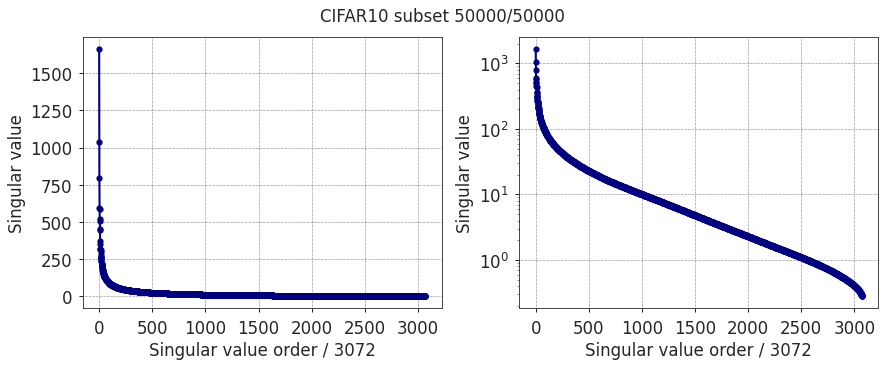

In [15]:
plt.figure(figsize = (2*6,5),dpi = 75)
plt.suptitle(dataset_choice+" subset "+str(subset_size)+"/"+str(len(x_train)),fontsize = 16)

plt.subplot(1,2,1)
plt.plot(train_singular_values,marker = "o",color = "navy")
plt.xlabel("Singular value order / 3072",fontsize = 16)
plt.ylabel("Singular value",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.subplot(1,2,2)
plt.semilogy(train_singular_values,marker = "o",color = "navy")
plt.xlabel("Singular value order / 3072",fontsize = 16)
plt.ylabel("Singular value",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

## Getting covariance matrices

In [16]:
x_train_flat = x_train.reshape([-1,32*32*3])
train_cov = onp.cov(x_train_flat[:],rowvar=False)

x_test_flat = x_test.reshape([-1,32*32*3])
test_cov = onp.cov(x_test_flat[:],rowvar=False)

In [17]:
train_cov_inv = onp.linalg.pinv(train_cov)

In [18]:
onp.trace(onp.matmul(train_cov_inv,test_cov))

3492.1186278269215

## Singular projection functions

In [20]:
def project_out(images_in, lvs_in, singular_values_to_project_out, proj_batch_size = 1,verbose = True):
  images_in_flat = images_in.reshape([len(images_in),-1])

  images_flat_remaining = onp.array(images_in_flat)

  its = int(onp.ceil(float(len(singular_values_to_project_out))/float(proj_batch_size)))

  for it in range(its):

    if verbose:
      print(it,"/",its)

    i1 = it*proj_batch_size
    i2 = min([(it+1)*proj_batch_size,len(singular_values_to_project_out)])

    singular_indices_now = singular_values_to_project_out[i1:i2]

    vectors_now = lvs_in[singular_indices_now] #the relevant singular vectors
    vectors_now_normed = vectors_now / jnp.linalg.norm(vectors_now,axis=1,keepdims=True)

    # projs_now = onp.einsum("ai,vi->av",images_flat_remaining,vectors_now_normed)
    projs_now = jnp.matmul(images_flat_remaining,vectors_now_normed.T)

    images_flat_remaining = images_flat_remaining - jnp.sum((jnp.expand_dims(projs_now,2))*(jnp.expand_dims(vectors_now_normed,0)),axis=1)

  return images_flat_remaining.reshape(images_in.shape) 

In [21]:
N_train = len(x_train)
N_test = len(x_test)

test_ds = {
  'image': x_test.astype(jnp.float32),
  'label': y_test.astype(jnp.int32)
}


# Experiments

In [22]:
train_ds = {
  'image': orig_x_train.astype(jnp.float32),
  'label': orig_y_train.astype(jnp.int32)
}

test_ds = {
  'image': x_test.astype(jnp.float32),
  'label': y_test.astype(jnp.int32)
}

#specify your experiments here, will be applied to train and test both
data_modifications_to_run = [
  ("original", []),
  ("remove top 5",onp.arange(5)),
  ("remove top 10",onp.arange(10)),
  # ("remove top 50",onp.arange(50)),
  # ("remove top 100",onp.arange(100)),
  ("remove top 200",onp.arange(200)),
  # ("remove top 350",onp.arange(350)),
  # ("remove top 500",onp.arange(500)),
  ("keep top 50",onp.arange(50,3072)),
  # ("keep top 100",onp.arange(100,3072)),
  ("keep top 500",onp.arange(500,3072)),
  # ("keep top 1000",onp.arange(1000,3072)),
]


modified_train_ds_list = []

for description,singular_vals_to_project_out in data_modifications_to_run:

  print("Data modification = "+description)

  modified_x_train_now = project_out(orig_x_train,train_lvs,singular_vals_to_project_out,proj_batch_size=5,verbose = False)

  train_ds_now = {
    'image': modified_x_train_now.astype(jnp.float32),
    'label': orig_y_train.astype(jnp.int32)
  }

  modified_train_ds_list.append(train_ds_now)


modified_test_ds_list = []

for description,singular_vals_to_project_out in data_modifications_to_run:

  print("Data modification = "+description)

  modified_x_test_now = project_out(x_test,train_lvs,singular_vals_to_project_out,proj_batch_size=5,verbose = False)

  test_ds_now = {
    'image': modified_x_test_now.astype(jnp.float32),
    'label': y_test.astype(jnp.int32)
  }

  modified_test_ds_list.append(test_ds_now)


Data modification = original
Data modification = remove top 5
Data modification = remove top 10
Data modification = remove top 200
Data modification = keep top 50
Data modification = keep top 500
Data modification = original
Data modification = remove top 5
Data modification = remove top 10
Data modification = remove top 200
Data modification = keep top 50
Data modification = keep top 500


# Visualization fn

In [23]:
def show_examples(batch, show_classes=[0], n_to_show_per_class = 5,title = None):

  n_to_show_per_class = 5

  for c in show_classes:
    bools_now = batch["label"] == c
    plt.figure(figsize = (n_to_show_per_class*2,2))

    if title is not None:
      plt.suptitle(title)

    for i in range(n_to_show_per_class):
      plt.subplot(1,n_to_show_per_class,i+1)
      plt.title("truth="+str(batch["label"][bools_now][i]))
      plt.imshow(onp.sum(batch["image"][bools_now][i],axis=-1),cmap = plt.cm.bwr)
      plt.xticks([],[])
      plt.yticks([],[])
    plt.show()


# An example of all modifications

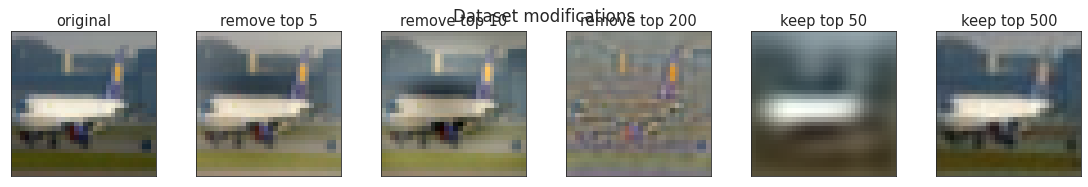

In [26]:
per_row = 6
rows = int(onp.ceil(float(len(data_modifications_to_run))/float(per_row)))
c = 0

plt.figure(figsize = (per_row*2.5,rows*2.5),dpi=75)

plt.suptitle("Dataset modifications",fontsize = 16)

for j in range(len(data_modifications_to_run)):

  plt.subplot(rows,per_row,j+1)

  plt.title(data_modifications_to_run[j][0],fontsize = 14)

  batch = modified_train_ds_list[j]

  bools_now = batch["label"] == c

  plt.imshow(((batch["image"][bools_now][i]+x_train_mean)*255).astype(onp.uint8))

  plt.xticks([],[])
  plt.yticks([],[])

plt.tight_layout()

plt.subplots_adjust(top=0.85)

plt.show()

# Model training loop

## Training setup

In [27]:
points_to_collect = 1 #how many times to train each settings
epochs = 5 #how many epochs for to train

batch_size = 128 

## The training loop (5 min on a GPU with default settings)

Training on train with the singular dierctions modification = original


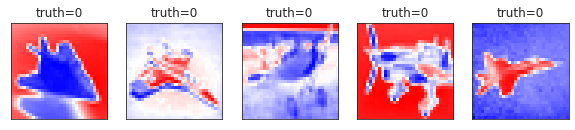

/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


Number of params = 273258
e=0.0 it=0 train loss=2.2939103 train acc=0.1328125 test loss=2.5731833 test acc=0.09770001 t_rem=TBD
e=0.9984 it=390 train loss=1.221137 train acc=0.578125 test loss=1.083406 test acc=0.61300004 t_rem=255
e=1.9968 it=780 train loss=0.9150777 train acc=0.71875 test loss=0.8646856 test acc=0.6951 t_rem=246
e=2.9952 it=1170 train loss=0.59422207 train acc=0.8046875 test loss=0.77429825 test acc=0.73020005 t_rem=238
e=3.9936 it=1560 train loss=0.628947 train acc=0.7578125 test loss=0.71217954 test acc=0.75390005 t_rem=229
e=4.992 it=1950 train loss=0.4530565 train acc=0.828125 test loss=0.6703419 test acc=0.76970005 t_rem=220
Training on train with the singular dierctions modification = remove top 5


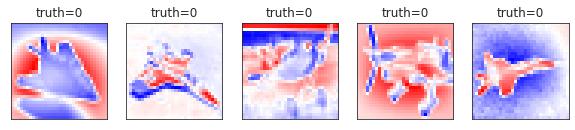

Number of params = 273258
e=0.0 it=0 train loss=2.3020535 train acc=0.1328125 test loss=2.6670597 test acc=0.0944 t_rem=TBD
e=0.9984 it=390 train loss=1.2129513 train acc=0.609375 test loss=1.2541522 test acc=0.5557 t_rem=211
e=1.9968 it=780 train loss=0.73352504 train acc=0.7734375 test loss=0.9843858 test acc=0.65330005 t_rem=202
e=2.9952 it=1170 train loss=0.79337335 train acc=0.7421875 test loss=0.9037138 test acc=0.6833 t_rem=193
e=3.9936 it=1560 train loss=0.5550908 train acc=0.7890625 test loss=0.8310779 test acc=0.71800005 t_rem=184
e=4.992 it=1950 train loss=0.6553363 train acc=0.7578125 test loss=0.8137696 test acc=0.7286 t_rem=176
Training on train with the singular dierctions modification = remove top 10


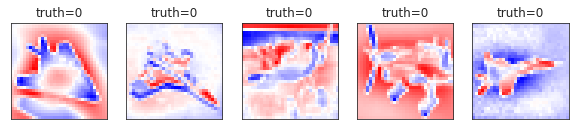

Number of params = 273258
e=0.0 it=0 train loss=2.3089182 train acc=0.0859375 test loss=2.600242 test acc=0.09590001 t_rem=TBD
e=0.9984 it=390 train loss=1.4600291 train acc=0.515625 test loss=1.4098798 test acc=0.499 t_rem=167
e=1.9968 it=780 train loss=0.6244562 train acc=0.78125 test loss=1.1299798 test acc=0.6043 t_rem=158
e=2.9952 it=1170 train loss=0.736098 train acc=0.7734375 test loss=0.97912836 test acc=0.66400003 t_rem=150
e=3.9936 it=1560 train loss=0.41499957 train acc=0.8671875 test loss=0.94902015 test acc=0.67880005 t_rem=141
e=4.992 it=1950 train loss=0.66769046 train acc=0.765625 test loss=0.97414935 test acc=0.6836 t_rem=132
Training on train with the singular dierctions modification = remove top 200


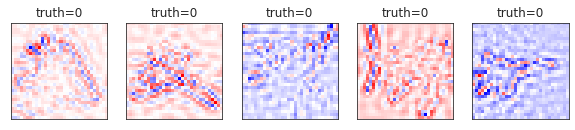

Number of params = 273258
e=0.0 it=0 train loss=2.2990067 train acc=0.125 test loss=2.7219262 test acc=0.0935 t_rem=TBD
e=0.9984 it=390 train loss=1.2564044 train acc=0.53125 test loss=2.7008772 test acc=0.23590001 t_rem=123
e=1.9968 it=780 train loss=1.0804799 train acc=0.6171875 test loss=2.5788903 test acc=0.29430002 t_rem=114
e=2.9952 it=1170 train loss=0.73830056 train acc=0.765625 test loss=2.2738545 test acc=0.34500003 t_rem=105
e=3.9936 it=1560 train loss=0.6077409 train acc=0.8203125 test loss=2.257185 test acc=0.37330002 t_rem=96
e=4.992 it=1950 train loss=0.683914 train acc=0.7890625 test loss=2.2811432 test acc=0.3864 t_rem=88
Training on train with the singular dierctions modification = keep top 50


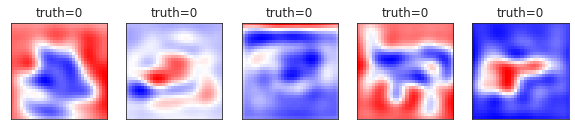

Number of params = 273258
e=0.0 it=0 train loss=2.2947924 train acc=0.1484375 test loss=2.569635 test acc=0.1014 t_rem=TBD
e=0.9984 it=390 train loss=1.3565996 train acc=0.5 test loss=1.4285914 test acc=0.47900003 t_rem=79
e=1.9968 it=780 train loss=1.3001802 train acc=0.5546875 test loss=1.3227438 test acc=0.52320004 t_rem=70
e=2.9952 it=1170 train loss=1.1753943 train acc=0.5859375 test loss=1.2287313 test acc=0.56200004 t_rem=61
e=3.9936 it=1560 train loss=0.9653278 train acc=0.671875 test loss=1.2041291 test acc=0.56640005 t_rem=52
e=4.992 it=1950 train loss=1.1601099 train acc=0.609375 test loss=1.1688284 test acc=0.58390003 t_rem=44
Training on train with the singular dierctions modification = keep top 500


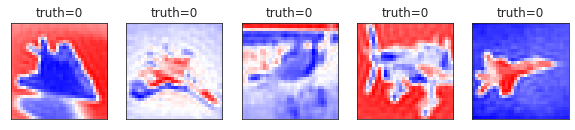

Number of params = 273258
e=0.0 it=0 train loss=2.2995305 train acc=0.0625 test loss=2.5717354 test acc=0.09730001 t_rem=TBD
e=0.9984 it=390 train loss=1.2685012 train acc=0.5625 test loss=1.0822496 test acc=0.60980004 t_rem=35
e=1.9968 it=780 train loss=0.6658226 train acc=0.7578125 test loss=0.895818 test acc=0.68170005 t_rem=26
e=2.9952 it=1170 train loss=0.75493026 train acc=0.7109375 test loss=0.80018365 test acc=0.71720004 t_rem=17
e=3.9936 it=1560 train loss=0.5779463 train acc=0.8046875 test loss=0.782994 test acc=0.72330004 t_rem=8
e=4.992 it=1950 train loss=0.65312165 train acc=0.7578125 test loss=0.73155564 test acc=0.75360006 t_rem=0


In [28]:
allexps_params_collected_by_iteration = []
allexps_states_collected_by_iteration = []

ts = []

for exp_i,(description,_) in enumerate(data_modifications_to_run):

  train_ds_touse = modified_train_ds_list[exp_i]
  print("Training on train with the singular dierctions modification = "+description)

  show_examples(train_ds_touse)

  # collecting train params and states
  params_collected_by_iteration = [[] for _ in range(points_to_collect)]
  states_collected_by_iteration = [[] for _ in range(points_to_collect)]

  #which iterations to save the params at
  def it_to_save_fn(it):
    return (it % 100 == 0) or (it in [0,1,2,3,4,5,6,7,8,9,10]) or ((10<it<100) and (it % 10 == 0))

  for point_id in range(points_to_collect):

    with flax.nn.stateful() as init_state_raw:
      _, initial_params = model_to_use.init_by_shape(jax.random.PRNGKey(point_id+9381577432), [((128, 32, 32, 3), jnp.float32)])
      model = flax.nn.Model(model_to_use, initial_params)
      init_state = init_state_raw

    state = init_state # for the batch norm params

    # optimizer = flax.optim.Momentum(learning_rate=0.1, beta=0.9).create(model) #the LR doesn't matter, it changes on every update based on the train fn
    optimizer = flax.optim.Adam(learning_rate=1e-3).create(model) #the LR doesn't matter, it changes on every update based on the train fn


    print("Number of params = "+str(onp.sum([onp.prod(x.shape) for x in jax.tree_flatten(initial_params)[0]])))
      
    params_collected_by_iteration[point_id].append((None,initial_params))
    states_collected_by_iteration[point_id].append((None,state))

    total_it = -1
    t1 = time.time()

    while True:

      #getting a random batch
      batch_ids = onp.random.choice(range(len(train_ds_touse["image"])),(batch_size),replace = False)
      batch = {
        "image": train_ds_touse["image"][batch_ids],
        "label": train_ds_touse["label"][batch_ids],
      }

      total_it = total_it + 1

      if total_it / (len(x_train)/float(batch_size)) > epochs:
        break

      #getting the update step
      optimizer,state = train_step(total_it, optimizer, batch, state)

      #getting the params out
      params_now = optimizer.target.params

      if it_to_save_fn(total_it): #collecting parameters as training progresses
        params_collected_by_iteration[point_id].append((total_it,params_now))
        states_collected_by_iteration[point_id].append((total_it,state))

      #batch loss and acc
      metrics = eval(optimizer.target, batch, state)
      loss_out = metrics["loss"]
      accuracy_out = metrics["accuracy"]

      e_float = total_it / (len(x_train)/float(batch_size))

      #looking at test set once every epoch
      if (total_it % int(len(x_train)/float(batch_size))) in [0]:  
        #test verification

        #doing the BN averaing on the test
        test_loss_out_testBN = normal_loss(params_now,test_ds)
        test_accuracy_out_testBN = normal_accuracy(params_now,test_ds)

        t2 = time.time()
        if total_it > 0:
          ts.append(t2-t1)
          t_rem_str = str(int(onp.mean(ts)*points_to_collect*epochs*len(data_modifications_to_run) - onp.sum(ts)))
        else:
          t_rem_str = "TBD" 
        t1 = time.time()


        print("e="+str(e_float)+
              " it="+str(total_it)+
              " train loss="+str(loss_out)+
              " train acc="+str(accuracy_out)+
              " test loss="+str(test_loss_out_testBN)+
              " test acc="+str(test_accuracy_out_testBN)+
              " t_rem="+str(t_rem_str)
              )
      
  allexps_params_collected_by_iteration.append(params_collected_by_iteration)
  allexps_states_collected_by_iteration.append(states_collected_by_iteration)


# Getting performance evaluations


Data modification = original


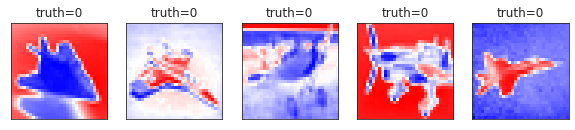

/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)



Data modification = remove top 5


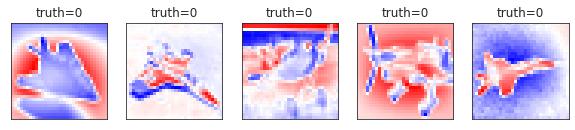


Data modification = remove top 10


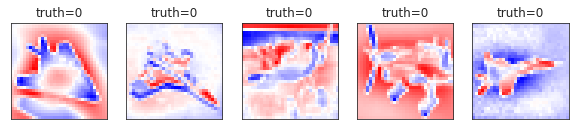


Data modification = remove top 200


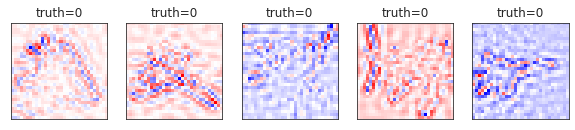


Data modification = keep top 50


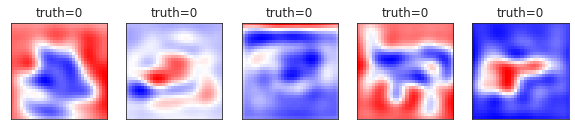


Data modification = keep top 500


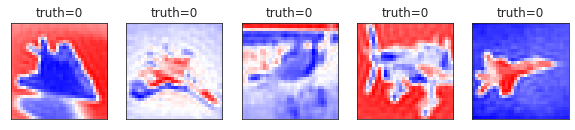

In [29]:
allexps_test_accs_grid = onp.zeros((len(data_modifications_to_run),len(data_modifications_to_run),points_to_collect))
allexps_test_preds_grid = onp.zeros((len(data_modifications_to_run),len(data_modifications_to_run),points_to_collect, len(y_test), classes))

for exp_i,(description,_) in enumerate(data_modifications_to_run):

  train_ds_touse = modified_train_ds_list[exp_i]

  print("")
  print("Data modification = "+str(description))

  show_examples(train_ds_touse)

  params_collected_by_iteration = allexps_params_collected_by_iteration[exp_i]
  states_collected_by_iteration = allexps_states_collected_by_iteration[exp_i]

  for i in range(points_to_collect):

    #final params
    params_now = params_collected_by_iteration[i][-1][1]

    for j in range(len(data_modifications_to_run)):

      test_ds_touse = modified_test_ds_list[j]

      test_preds_now = model_to_use.call(params_now, test_ds_touse["image"])
      test_acc_now = onp.mean(onp.argmax(test_preds_now,axis=-1) == test_ds_touse["label"],axis=-1)

      allexps_test_accs_grid[exp_i,j,i] = test_acc_now
      allexps_test_preds_grid[exp_i,j,i] = jax.nn.softmax(test_preds_now)





## Plot 1: Test acc on modified test as a fn of train mod

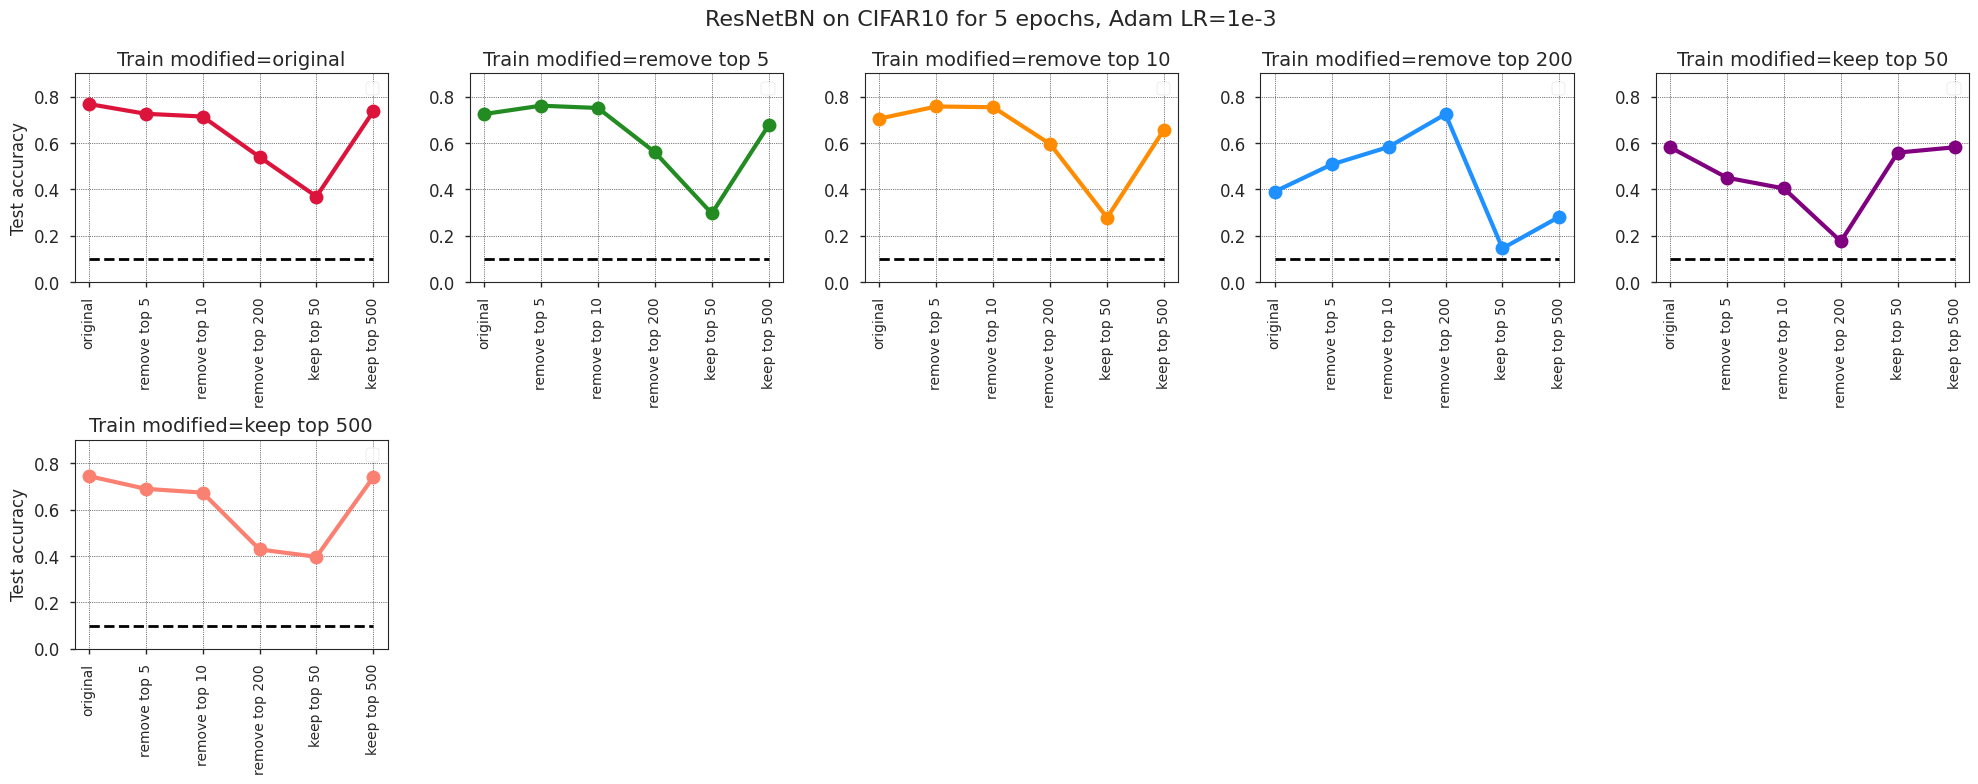

In [32]:
allexps_test_accs_grid_mean = onp.mean(allexps_test_accs_grid,axis=2)
allexps_test_accs_grid_error = onp.std(allexps_test_accs_grid,axis=2)

per_row = 5
rows = int(onp.ceil(float(len(data_modifications_to_run))/float(per_row)))

plt.figure(figsize = (per_row*4,rows*4),dpi=100)

plt.suptitle(model_name+" on "+dataset_choice+" for "+str(epochs)+" epochs, Adam LR=1e-3",fontsize = 16)

for j in range(len(data_modifications_to_run)):

  plt.subplot(rows,per_row,j+1)

  plt.title("Train modified="+str(data_modifications_to_run[j][0]),fontsize = 14)

  markers_list = ["o","s","v","^"]
  colors_list = ["crimson","forestgreen","darkorange","dodgerblue","purple","salmon","navy","teal","tomato","darkgreen"]

  xvals = onp.arange(len(data_modifications_to_run))

  line, = plt.plot(
      xvals, 
      allexps_test_accs_grid_mean[j,:],
      marker = "o",
      color = colors_list[j % len(colors_list)],
      linewidth = 3,
      markersize = 10,
      )
  
  plt.fill_between(
      xvals, 
      allexps_test_accs_grid_mean[j,:]-allexps_test_accs_grid_error[j,:],
      allexps_test_accs_grid_mean[j,:]+allexps_test_accs_grid_error[j,:],
      color = line.get_color(),
      alpha = 0.3,
  )

  plt.plot(xvals,[1.0/classes]*len(data_modifications_to_run),marker = "",linestyle = "--",color = "black")

  # if j // per_row == rows-1:
  #   plt.xlabel("Number of top singulars\nremoved from test",fontsize = 12)

  if j % per_row == 0:
    plt.ylabel("Test accuracy",fontsize = 12)

  plt.ylim([0.0,0.9])

  plt.xticks(xvals, [q[0] for q in data_modifications_to_run] ,fontsize = 10,rotation=90)
  plt.yticks(fontsize = 12)

  plt.legend(fontsize = 12)

plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.show()

## Plot 2: Test acc on modified test as a fn of test mod

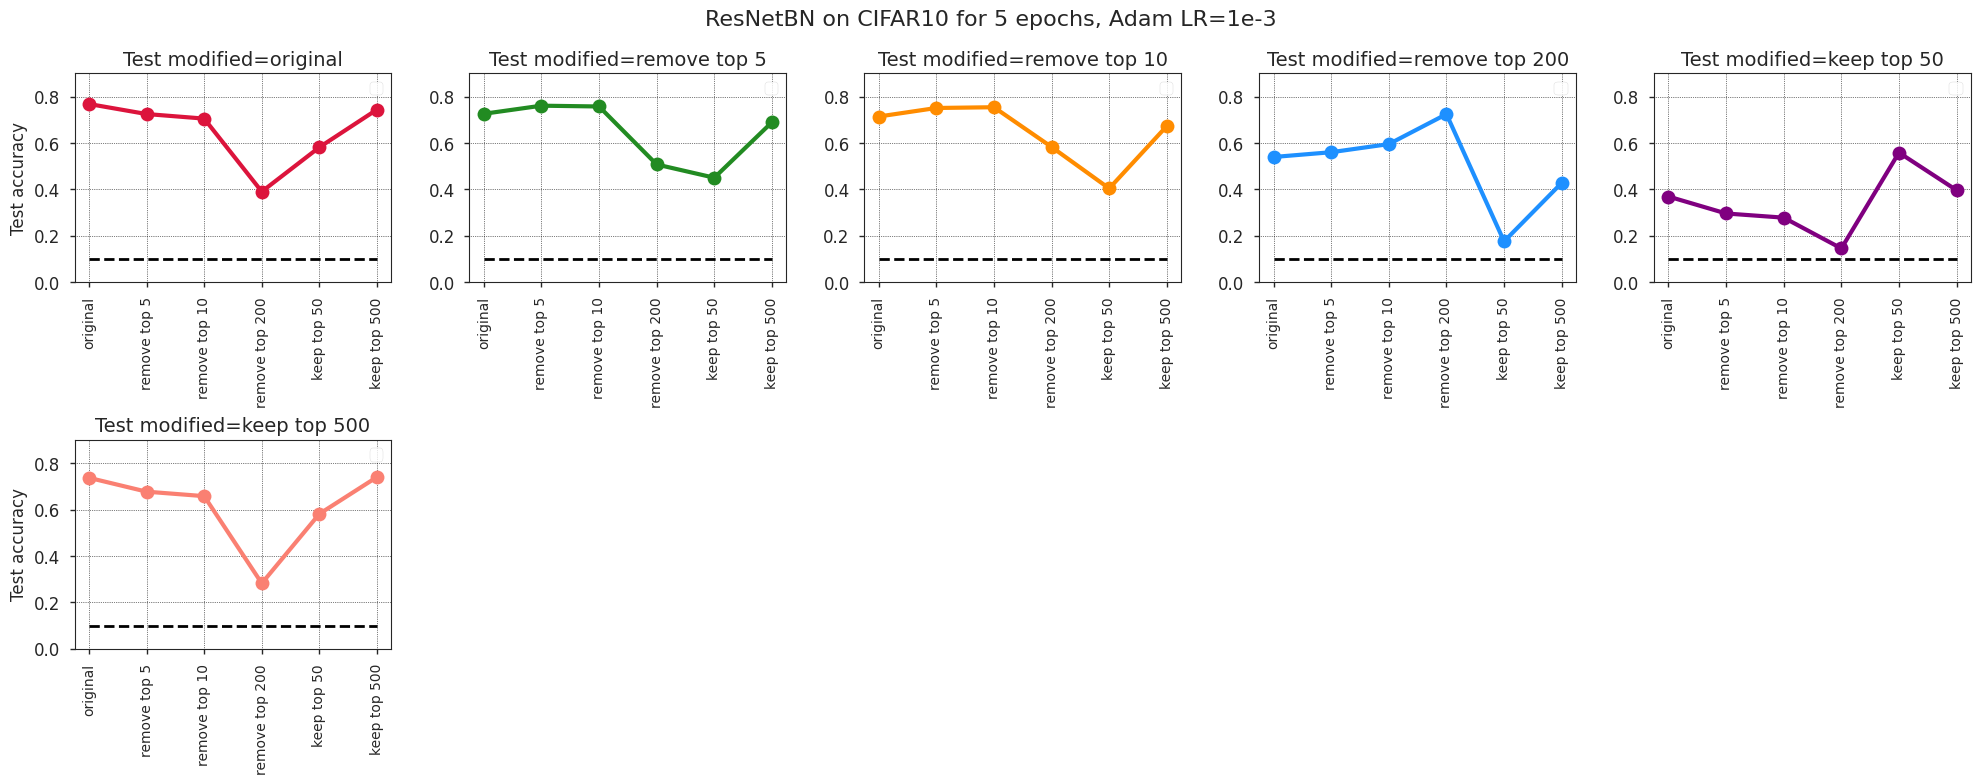

In [33]:
allexps_test_accs_grid_mean = onp.mean(allexps_test_accs_grid,axis=2)
allexps_test_accs_grid_error = onp.std(allexps_test_accs_grid,axis=2)

per_row = 5
rows = int(onp.ceil(float(len(data_modifications_to_run))/float(per_row)))

plt.figure(figsize = (per_row*4,rows*4),dpi=100)

plt.suptitle(model_name+" on "+dataset_choice+" for "+str(epochs)+" epochs, Adam LR=1e-3",fontsize = 16)

for j in range(len(data_modifications_to_run)):

  plt.subplot(rows,per_row,j+1)

  plt.title("Test modified="+str(data_modifications_to_run[j][0]),fontsize = 14)

  markers_list = ["o","s","v","^"]
  colors_list = ["crimson","forestgreen","darkorange","dodgerblue","purple","salmon","navy","teal","tomato","darkgreen"]

  xvals = onp.arange(len(data_modifications_to_run))

  line, = plt.plot(
      xvals, 
      allexps_test_accs_grid_mean[:,j],
      marker = "o",
      color = colors_list[j % len(colors_list)],
      linewidth = 3,
      markersize = 10,
      )
  
  plt.fill_between(
      xvals, 
      allexps_test_accs_grid_mean[:,j]-allexps_test_accs_grid_error[:,j],
      allexps_test_accs_grid_mean[:,j]+allexps_test_accs_grid_error[:,j],
      color = line.get_color(),
      alpha = 0.3,
  )

  plt.plot(xvals,[1.0/classes]*len(data_modifications_to_run),marker = "",linestyle = "--",color = "black")

  # if j // per_row == rows-1:
  #   plt.xlabel("Number of top singulars\nremoved from test",fontsize = 12)

  if j % per_row == 0:
    plt.ylabel("Test accuracy",fontsize = 12)

  plt.ylim([0.0,0.9])

  plt.xticks(xvals, [q[0] for q in data_modifications_to_run] ,fontsize = 10,rotation=90)
  plt.yticks(fontsize = 12)

  plt.legend(fontsize = 12)

plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.show()

## Plot 3: All train mods vs all test mods all combinations

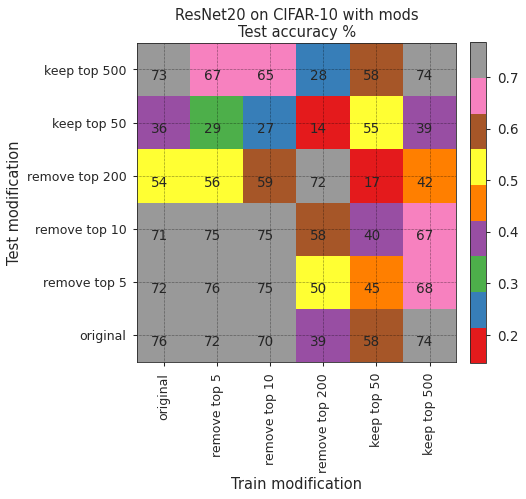

In [34]:
plt.figure(figsize = (6,6),dpi=75)

plt.title("ResNet20 on CIFAR-10 with mods\nTest accuracy %",fontsize = 14)

xvals = onp.arange(len(data_modifications_to_run))
plt.xticks(xvals, [q[0] for q in data_modifications_to_run] ,fontsize = 12,rotation=90)
plt.xlabel("Train modification",fontsize = 14)

yvals = onp.arange(len(data_modifications_to_run))
plt.yticks(yvals, [q[0] for q in data_modifications_to_run] ,fontsize = 12,rotation=0)
plt.ylabel("Test modification",fontsize = 14)

plt.imshow(allexps_test_accs_grid_mean[:].T,origin="lower",cmap = "Set1")
plt.colorbar(fraction=0.046, pad=0.04)

for i in range(len(data_modifications_to_run)):
  for j in range(len(data_modifications_to_run)):
    text = str(int(allexps_test_accs_grid_mean[i,j]*100))
    plt.text(i-0.25,j-0.20,text)

plt.show()